In [1]:
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 34.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [34]:
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import UnivariateSpline

# Load data from CSV files
df = pd.read_csv("DCCrho_bba_ypf.csv", index_col=0, parse_dates=True)
df_exchange_rate = pd.read_csv("exchange_rates_brl_ars.csv", index_col=0, parse_dates=True)
df_oil_price = pd.read_csv("oil_data.csv", index_col=0, parse_dates=True)

# Merge all DataFrames on index
merged_df = pd.merge(df, df_exchange_rate, how='outer', left_index=True, right_index=True)
merged_df = pd.merge(merged_df, df_oil_price, how='outer', left_index=True, right_index=True)

# If your index is not a datetime type, convert it to datetime
merged_df.index = pd.to_datetime(merged_df.index)

# For example, if your data is daily, set the frequency to 'D'
merged_df = merged_df.asfreq('D')

def fill_missing_with_spline(series):
    # Extract indices of null values
    null_indices = series[series.isnull()].index
    # Extract non-null values
    non_null_values = series.dropna()
    # Create spline interpolation object with specified s value
    spline = UnivariateSpline(non_null_values.index.astype(int), non_null_values.values, s=2)
    # Interpolate null values
    interpolated_values = spline(null_indices.astype(int))
    # Replace null values with interpolated values
    series.loc[null_indices] = interpolated_values
    return series

# Apply spline interpolation to each column of the DataFrame
merged_df = merged_df.apply(fill_missing_with_spline, axis=0)

# Initialize StandardScaler
scaler = StandardScaler()

# Extract exchange rate and oil price data
exchange_rate_brl = merged_df['USDBRL.X.Adjusted'].values.reshape(-1, 1)
exchange_rate_ars = merged_df['USDARS.X.Adjusted'].values.reshape(-1, 1)

oil_price_data = merged_df['CL.F.Adjusted'].values.reshape(-1, 1)

# Fit scaler on training data (compute mean and standard deviation)
scaler.fit(exchange_rate_brl)
scaler.fit(exchange_rate_ars)
scaler.fit(oil_price_data)

# Standardize exchange rate and oil price data
scaled_exchange_rate_brl = scaler.transform(exchange_rate_brl)
scaled_exchange_rate_ars = scaler.transform(exchange_rate_ars)
scaled_oil_price_data = scaler.transform(oil_price_data)

# Update DataFrame with scaled data
merged_df['Scaled_Exchange_Rate_BRL'] = scaled_exchange_rate_brl
merged_df['Scaled_Exchange_Rate_ARS'] = scaled_exchange_rate_ars
merged_df['Scaled_Oil_Price'] = scaled_oil_price_data


# Convert the DataFrame into a PandasDataset
dataset = PandasDataset(
    dataframes=merged_df,
    target="DCCrho",
    feat_dynamic_real=["Scaled_Exchange_Rate_BRL",
                       "Scaled_Exchange_Rate_ARS",
                       "Scaled_Oil_Price"]  # Specify the dynamic features
)


In [35]:
dataset

PandasDataset<size=1, freq=D, num_feat_dynamic_real=3, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [36]:
from gluonts.dataset.split import split

training_data, test_gen = split(dataset, offset=-240)

test_data = test_gen.generate_instances(prediction_length=5, windows=48)


In [37]:
# Train the model
model = DeepAREstimator(
    prediction_length=5,
    freq="D",
    dropout_rate=0.5,
    num_layers=4,
    lr=0.06,
    trainer_kwargs={"max_epochs": 10}
).train(training_data)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | In sizes                                                        | Out sizes  
----------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 52.1 K | [[1, 1], [1, 1], [1, 1097, 4], [1, 1097], [1, 1097], [1, 5

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -1.05430 (best -1.05430), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.05430 (best -1.05430), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -1.99995 (best -1.99995), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.99995 (best -1.99995), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -2.24956 (best -2.24956), saving model to '/content/lightning_logs/version_7/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global s

In [38]:
forecasts = list(model.predict(test_data.input))

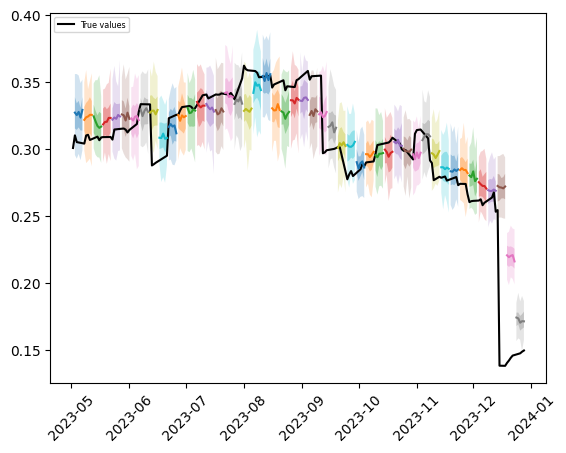

In [39]:
# Plot predictions
plt.plot(df["2023-05":], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-small")
plt.xticks(rotation=45)
plt.show()